<a href="https://colab.research.google.com/github/JosueGarridoS/AmphoraChallenge/blob/main/AmphoraHealth_CodingChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cancer Statistics in North America

### Student Internship Data Challenge 2021

The overall objective of the 2021 Amphora Health Student Internship is to follow-up on the
cancer statistics in the North American region. As the societies of the three countries are
getting intertwined due to commerce, policy, and migration, our understanding of the basic
cancer statistics (incidence, prevalence, mortality) is still limited. The goal of this internship
is to explore the available cancer data and build tools to facilitate the work of policy makers
and public health officials. Ultimately, the deliverable of this internship will be a research
product in the form of a conference poster, or even a full research manuscript, to showcase
the findings of this project.

The data challenge is designed to identify the best candidate possible. This is an integral
part of our recruitment process.


## 1. Instructions

**Data input**. You will be provided with CSV files containing summary statistics about all
types of cancer in each country in North America (Mexico, USA, Canada). For each country,
you will find two files referring to 1) incidence, and 2) mortality which represent the
reported information to the World Health Organization (WHO)’s International Agency for
Research on Cancer (IARC) by each country in 2020. For additional information and detailed
definitions please refer to the IARC website (https://gco.iarc.fr/today/about).

**Programming language**. You are required to generate this challenge in a Github repository,
and to generate a script in the programming language of your preference. We recommend
the use of R or Python, but your preferred language should be fine as well. The pipeline
should be designed in such a way that we can feed in data from any other three countries
and get new results automatically.

# **Task 1**. 

Your first task is to merge all the files into a single table to construct a summarized
view of this information across North America.

**Deliverable 1**. The table should be constructed in the following way:

● The rows of the table should be the categories of cancer. In each provided file, the first column shows the cancer diagnosis using the International Classification of Diseases version 10 (ICD-10). You are required to group these codes into top-level categories of cancer, as shown in the subchapters in the following link https://www.icd10data.com/ICD10CM/Codes/C00-D49 . For example the codes for liver cancer (C22) and pancreatic cancer (C25) are in the range C15-C26, so these two rows should be aggregated together.

● The columns of the table are the aggregated information for North America,
followed by the individual information from each country. Two columns are required for each of these, showing the incidence and mortality total numbers.

● The deliverable table should be generated automatically by your program or script.

In [1]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def df_of_region(path_incidence, path_mortality,country):
  """Returns a pandas DataFrame with the information of incidence and mortality
     of a country and the sum of the region.
     The information is ordered according to the Classification of Diseases
     version 10 (ICD-10)"""
  
  #Declaration of needed variables, DataFrames from csv files and lists to 
  #iterate when needed
  df_incidence = pd.read_csv(path_incidence)
  df_mortality  = pd.read_csv(path_mortality)
  ICD_groups = ["C00", "C15", "C30", "C40", "C43", "C45", "C50", "C51", "C60", 
                "C64", "C69", "C73", "C76", "C81", "C97"]
  ICD_index = ["-C14", "-C26", "-C39", "-C41", "-C44", "-C49", "-C50", "-C58",
               "-C63", "-C68", "-C72", "-C75", "-C80", "-C96", ""]
  country_incidence = []
  country_mortality = []
  NA_incidence = []
  NA_mortality = []
  index_list = []

  #This loop iterates through every element of the DataFrame and organizes them 
  #according to the (ICD-10)
  for i in range(1, 15):
    temp_list_in = [x for x in df_incidence.sort_index().index if x < ICD_groups[i] 
                    and x > ICD_groups[i-1] and x != "C00-97"]
    temp_list_mo = [x for x in df_mortality.sort_index().index if x < ICD_groups[i] 
                    and x > ICD_groups[i-1] and x != "C00-97"]
    country_incidence.append(df_incidence.Cancer[temp_list_in].sum())
    country_mortality.append(df_mortality.Cancer[temp_list_mo].sum())
    NA_incidence.append(df_incidence.Cancer[temp_list_in].sum())
    NA_mortality.append(df_mortality.Cancer[temp_list_mo].sum())

    
  #Adds the mortality and incidence numbers to fit the described cathegories and 
  #creates the expected DataFrame
  for (num_one, num_two) in zip(ICD_groups, ICD_index):
    index_list.append(num_one+num_two)
  df_result = pd.DataFrame(list(zip(NA_incidence,NA_mortality, country_incidence, 
                                    country_mortality)), index = index_list[:-1])
  col_ix = pd.MultiIndex.from_product([["North America", country], 
                                       ["Incidence", "Mortality"]])
  df_result.columns = col_ix

  return df_result

In [71]:
def add_to_main_df(path_incidence, path_mortality, country, main_df):
  """Adds a country to an existing DataFrame with the expected characteristics
     and adds quantities to the region column
  """

  #Creates a new DataFrame with the expected values (incidence and mortality),
  #and concatenates it ot the existing
  temp_df = df_of_region(path_incidence, path_mortality,country)
  df_result = pd.concat([main_df, temp_df], axis=1)
  df_result.groupby(level=1, axis=1).sum()
  
  #Adds the values of the new country to the column for the region
  temp_sum = main_df["North America"] + temp_df["North America"]
  temp_sum.columns = pd.MultiIndex.from_product([["North America"],
                                                 ["Incidence", "Mortality"]])
  df_result = df_result.drop(axis=1, columns = "North America", level = 0)
  df_result = pd.concat([temp_sum, df_result], axis=1)
  
  return df_result

In [99]:
def df_from_zip(zip_file_path, country_one, country_two, country_three):
  """Takes zip file with the csv files with information of the countries of a
  region and retruns a DataFrame with the required characteristics
  """
  #Declaration of the variables that will be used for the creation of the DataFrame
  zfile = zipfile.ZipFile('/content/ChallengeCancer.zip',"r")
  list_files = []
  for i in range(len(zfile.namelist())):
    list_files.append(zfile.extract(zfile.namelist()[i]))

  list_countries = []
  list_countries.append([x for x in list_files if country_one.lower() in
                         x.title().lower()])
  list_countries.append([x for x in list_files if country_two.lower() in
                         x.title().lower()])
  list_countries.append([x for x in list_files if country_three.lower() in
                         x.title().lower()])

  #Creates the DataFrame using the first country (df_of_region function)
  result_df = []
  for i in list_countries:
    if country_one.lower() in i[0].title().lower():
      if "newcases" in i[0].title().lower():
        result_df = df_of_region(i[0], i[1], country_one)
      else:
        result_df = df_of_region(i[1], i[0], country_one)

  #Includes the rest of the countries and adds their information to the region column 
  for i in list_countries:
    if country_one.lower() not in i[0].title().lower():
      if country_two.lower() in i[0].title().lower():
        if "newcases" in i[0].title().lower():
          result_df = add_to_main_df(i[0], i[1], country_two,df)
        else:         
          result_df = add_to_main_df(i[1], i[0], country_two,df)
      elif country_three.lower() in i[0].title().lower():
        if "newcases" in i[0].title().lower():
          result_df = add_to_main_df(i[0], i[1], country_three, df)
        else:
          result_df = add_to_main_df(i[1], i[0], country_three, df)

  return result_df

In [107]:
def df_from_zip(zip_file_path, country_one, country_two, country_three):
  """Takes zip file with the csv files with information of the countries of a
  region and retruns a DataFrame with the required characteristics
  """
  #Declaration of the variables that will be used for the creation of the DataFrame
  zfile = zipfile.ZipFile('/content/ChallengeCancer.zip',"r")
  list_files = []
  for i in range(len(zfile.namelist())):
    list_files.append(zfile.extract(zfile.namelist()[i]))

  list_countries = []
  list_countries.append([x for x in list_files if country_one.lower() in
                         x.title().lower()])
  list_countries.append([x for x in list_files if country_two.lower() in
                         x.title().lower()])
  list_countries.append([x for x in list_files if country_three.lower() in
                         x.title().lower()])

  #Creates the DataFrame using the first country (df_of_region function) and
  #then adds the rest to that existing DataFrame (add_to_main function)
  result_df = []
  if "newcases" in list_countries[0][0].title().lower():
      result_df = df_of_region(list_countries[0][0], list_countries[0][1], country_one)
  else:
      result_df = df_of_region(list_countries[0][1], list_countries[0][0], country_one)

  if "newcases" in list_countries[1][0].title().lower():
      result_df = add_to_main_df(list_countries[1][0], list_countries[1][1], country_two, result_df)
  else:
      result_df = add_to_main_df(list_countries[1][1], list_countries[1][0], country_two, result_df)

  if "newcases" in list_countries[2][0].title().lower():
      result_df = add_to_main_df(list_countries[2][0], list_countries[2][1], country_three, result_df)
  else:
      result_df = add_to_main_df(list_countries[2][1], list_countries[2][0], country_three, result_df)

  return result_df

In [ ]:
new_df = df_of_region('/content/canada-newcases.csv', '/content/canada-mortality.csv', "Canada")
new_df

In [ ]:
new_df_two = add_to_main_df('/content/mexico-newcases.csv', '/content/mexico-mortality.csv', "Mexico", new_df)
new_df_two

In [ ]:
df= add_to_main_df('/content/usa-newcases.csv', '/content/usa-mortality.csv', "USA", new_df_two)
df

In [157]:
df_res = df_from_zip("/content/ChallengeCancer.zip", "Canada", "Mexico", "USA")
df_res

North America              Canada  ...    Mexico       USA          
            Incidence Mortality Incidence  ... Mortality Incidence Mortality
C00-C14         54401     12619      5338  ...      1142     46310      9905
C15-C26        362254    195184     39868  ...     27177    284875    146918
C30-C39        275607    171556     26561  ...      7758    240429    142058
C40-C41             0         0         0  ...         0         0         0
C43-C44             0         0         0  ...         0         0         0
C45-C49          1739       235        58  ...       136      1078        92
C50-C50             0         0         0  ...         0         0         0
C51-C58        131737     44651     11045  ...      8609    100549     31939
C60-C63        280178     45809     31180  ...      8127    218919     32888
C64-C68        176262     42248     16729  ...      4422    150186     32719
C69-C72         30711     23257      2984  ...      2571     24538     18133
C73-C75             0         0         0  ...         0         0         0
C76-C80             0         0         0  ...         0         0         0
C81-C96        201412     75614     18304  ...      9395    166923     58037

[14 rows x 8 columns]

# **Task 2**. 

Your second task is to generate a scatter plot of the data with the intent of
identifying any insights that might arise from this visualization.

**Deliverable 2**. The scatter plot should have the following characteristics:

● The X-axis should show the cancer incidence.

● The Y-axis should show the cancer mortality.

● Each observation (dot or bubble) in the scatter plot should be one cancer category
(e.g. COO-C14)

● The color of the bubble should represent the country of the observation (four colors
total to include the region overall numbers)

● The size of the bubble should represent the relative numbers. Larger numbers
should have a larger bubble, and smaller numbers should have smaller bubbles.

**Additional considerations**. When developing this project, you should be thinking about
which are the interesting points of the scatter-plot? Are there any outliers in the data? Can
we identify any insights to be drawn from the data?

In [158]:
def plot_region(df):
  """Creates the plot of a DataFrame with the characteristics of the one created
  by df_of_region and add_to_main functions
  """

  #Variables that indicate the size of the dots (in realation with the ICD indices)
  #and countries assigned to each color
  size_of_dot = np.arange(10,df.index.size*20+10,20)*10
  a = df.columns.get_level_values(0)
  _, idx = np.unique(a, return_index=True)
  countries = a[np.sort(idx)]
  
  #Plots all the countries information as displayed
  for frame in [df[countries[0]], df[countries[1]], df[countries[2]], df[countries[3]]]:
    plt.scatter(frame["Incidence"], frame["Mortality"], s=size_of_dot, alpha=0.4)  
  plt.title("Statistics in North America")
  plt.xlabel("Incidence")
  plt.ylabel("Mortality")
  plt.rcParams["figure.figsize"] = (15,5)
  plt.legend(countries)
  plt.show()

  #Plots the same information with a limit of 50,000 by 50,000 and without the
  #rows with value 0 for clarity
  short_df = df[(df.T != 0).any()]
  size_of_dot = np.arange(10,short_df.index.size*20+10,20)*10
  fig = plt.figure()
  for frame in [short_df[countries[0]], short_df[countries[1]], short_df[countries[2]], short_df[countries[3]]]:
    plt.scatter(frame["Incidence"], frame["Mortality"], s=size_of_dot, alpha=0.4) 
  plt.title("Limited to 50,000") 
  plt.xlabel('Incidence')
  plt.ylabel('Mortality')
  plt.rcParams["figure.figsize"] = (15,5)
  plt.legend(countries)
  plt.xlim(0,50000)
  plt.ylim(0,50000)
  plt.show()

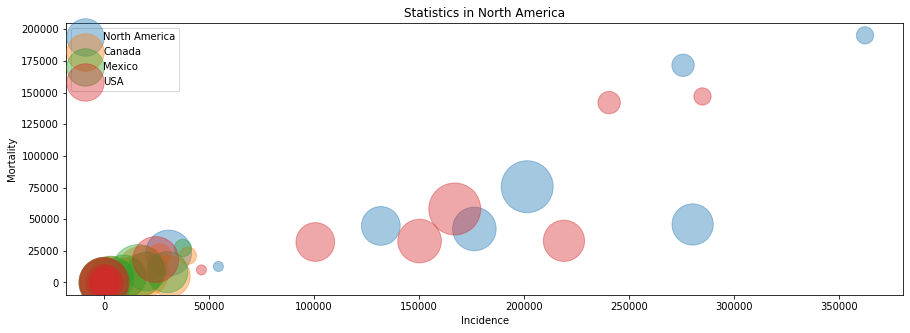

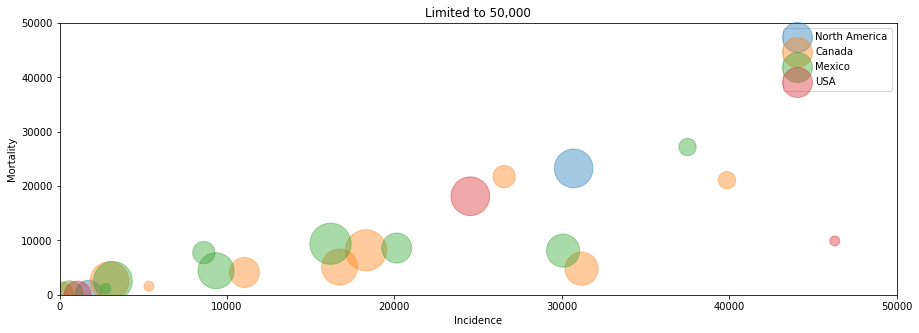

In [159]:
plot_region(df_res)

# Conclusions from observing the data

Which are the interesting points of the scatter-plot?

The first observation I can make while observing the graph is that regsrdless of the cancer classification, they all have a similar incidence-mortality satio

The points representing USA's cases are more spread, meaning that most registered cases in the region belong there which could tell us that just by observing the graph of the region, (North America) our conclusions might not reflect the situation of the other countries like Mexico (the one with least cases registered).



Are there any outliers in the data?

Because of the ICD classification we can see that the data lacks information on several types of cancer included in the following classifications: C40-C44, C50, C73-C80. This and the fact that the general information of the region and the USA registered cases make the graph convoluted while approaching (0,0) but since there seems to be a linear tendency, there are no obvious outliers.

Can we identify any insights to be drawn from the data?

The graph shows a linear tendency between the incidence and the mortality, regardless of the tyes of cancer the points represent, but considering the difference of cases between the countries, and the lack of information for certain types of cancer, these conclusions might only work for the region as a and whole to a certain point